# Importing Required Libraries

In [1]:
import pandas as pd 
import numpy as np 
import sys
import warnings
import itertools
warnings.filterwarnings("ignore")
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import calendar
import seaborn as sns
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

Importing the Dataset

In [2]:
data = pd.read_csv('Champagne.csv')
data.head()

,Month,Sales
0,1964-01,2815
1,1964-02,2672
2,1964-03,2755
3,1964-04,2721
4,1964-05,2946


Creating a date range

In [3]:
dates = pd.date_range(start='1964-01-01', freq='MS', periods=len(data))
dates[0:5]

DatetimeIndex(['1964-01-01', '1964-02-01', '1964-03-01', '1964-04-01',
               '1964-05-01'],
              dtype='datetime64[ns]', freq='MS')

In [4]:
data.set_index(dates,inplace=True)

In [5]:
sales_ts = data['Sales']
sales_ts[0:5]

1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
Freq: MS, Name: Sales, dtype: int64

# Modeling

In [6]:
data = pd.DataFrame(sales_ts.copy())
data.head()

,Sales
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946


In [7]:
# Splitting Train and Test Length
train_len = int(np.ceil(len(data) * 0.75))

In [8]:
train=data[0:train_len] 
test=data[train_len:]
print('Train data length :',len(train))
print('Test  data length :',len(test))

Train data length : 79
Test  data length : 26


In [9]:
x_train = train.drop('Sales', axis=1)
x_test = test.drop('Sales', axis=1)
y_train = train[['Sales']]
y_test = test[['Sales']]

# Model 1: Simple Average

In [10]:
y_hat_avg = test.copy()

In [11]:
y_hat_avg['avg_forecast'] = train['Sales'].mean()

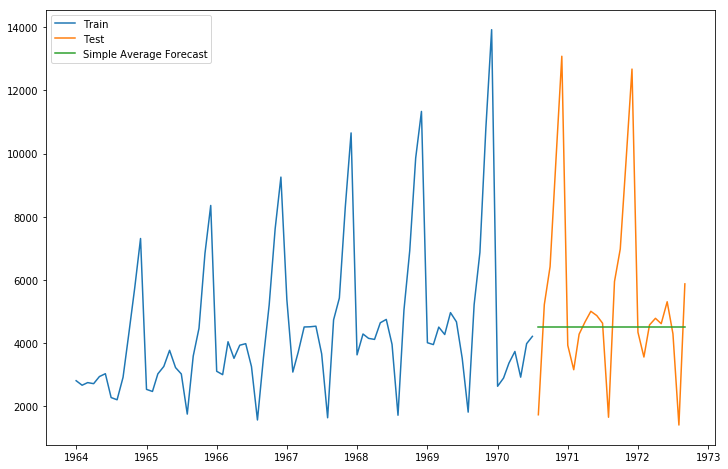

In [12]:
plt.figure(figsize=(12,8))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Simple Average Forecast')
plt.legend(loc='best')
plt.show()

In [13]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales, y_hat_avg.avg_forecast))
rmse = round(rmse, 3)

In [14]:
# Mean Absolute Percentage Error
abs_error = np.abs(y_test['Sales']-y_hat_avg.avg_forecast)
actual = y_test['Sales']
mape = np.round(np.mean(abs_error/actual),4)
resultsDf = pd.DataFrame({'Method':['Simple average forecast'], 'RMSE': [rmse]})
resultsDf

,Method,RMSE
0,Simple average forecast,3040.268


In [15]:
# Storing results in a dataframe
resultsDf = pd.DataFrame({'Method':['Simple average forecast'], 'MAPE': [mape], 'RMSE': [rmse]})
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,Simple average forecast,3040.268,0.4084


# Model 2: Moving Average(MA)

In [16]:
df1 = data.copy()

### Grid Search to determine the best rolling window

In [17]:
for i in range(1,13):
    df1['moving_avg_forecast'] = data['Sales'].rolling(i).mean()
    train=df1[0:train_len] 
    test=df1[train_len:]
    y_hat_avg = test.copy()
    rmse = np.sqrt(mean_squared_error(test.Sales, y_hat_avg.moving_avg_forecast))
    abs_error = np.abs(y_test['Sales']-y_hat_avg.moving_avg_forecast)
    actual = y_test['Sales']
    mape = np.round(np.mean(abs_error/actual),4)
    print('Rolling window : ',i,'RMSE : ' ,np.round(rmse,2) ,'MAPE : ',mape)

Rolling window :  1 RMSE :  0.0 MAPE :  0.0
Rolling window :  2 RMSE :  1619.83 MAPE :  0.283
Rolling window :  3 RMSE :  2259.1 MAPE :  0.4391
Rolling window :  4 RMSE :  2589.39 MAPE :  0.5007
Rolling window :  5 RMSE :  2811.84 MAPE :  0.5336
Rolling window :  6 RMSE :  2831.3 MAPE :  0.5322
Rolling window :  7 RMSE :  2824.16 MAPE :  0.5107
Rolling window :  8 RMSE :  2864.43 MAPE :  0.5151
Rolling window :  9 RMSE :  3004.95 MAPE :  0.5828
Rolling window :  10 RMSE :  3057.59 MAPE :  0.5862
Rolling window :  11 RMSE :  3046.6 MAPE :  0.5581
Rolling window :  12 RMSE :  2933.69 MAPE :  0.5247


Choosing rolling window as 2 since it gives the less MAPE score

In [18]:
df1['moving_avg_forecast'] = data['Sales'].rolling(2).mean()

In [19]:
#Creating train and test set 
train=df1[0:train_len] 
test=df1[train_len:]

In [20]:
y_hat_avg = test.copy()

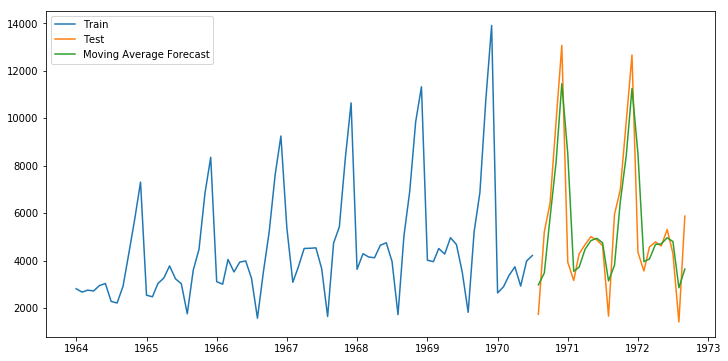

In [21]:
plt.figure(figsize=(12,6))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

In [22]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales, y_hat_avg.moving_avg_forecast))
rmse = round(rmse, 3)

In [23]:
# Mean Absolute Percentage Error
abs_error = np.abs(y_test['Sales']-y_hat_avg.moving_avg_forecast)
actual = y_test['Sales']
mape = np.round(np.mean(abs_error/actual),4)

In [24]:
# Storing results in a dataframe
tempResultsDf = pd.DataFrame({'Method':['Moving average forecast'], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,Simple average forecast,3040.268,0.4084
0,Moving average forecast,1619.835,0.2830


# Model 3: Simple Exponential Smoothing

In [25]:
# create class
model = SimpleExpSmoothing(train['Sales'])

### Grid Search to acquire best Smoothing_level(alpha)

In [26]:
for i in np.arange(0.1,1,0.1):
    model_fit = model.fit(smoothing_level=i,optimized=False)
    y_hat_avg = test.copy()
    y_hat_avg['SES'] = model_fit.forecast(len(test['Sales']))
    rmse = np.sqrt(mean_squared_error(test.Sales, y_hat_avg.SES))
    rmse = round(rmse, 3)
    abs_error = np.abs(y_test['Sales']-y_hat_avg.SES)
    actual = y_test['Sales']
    mape = np.round(np.mean(abs_error/actual),4)
    print('smoothing_level : ',np.round(i,1),'RMSE : ' ,np.round(rmse,2) ,'MAPE : ',mape)

smoothing_level :  0.1 RMSE :  2944.82 MAPE :  0.4351
smoothing_level :  0.2 RMSE :  3064.14 MAPE :  0.4068
smoothing_level :  0.3 RMSE :  3186.27 MAPE :  0.4093
smoothing_level :  0.4 RMSE :  3252.21 MAPE :  0.4139
smoothing_level :  0.5 RMSE :  3261.95 MAPE :  0.4146
smoothing_level :  0.6 RMSE :  3241.12 MAPE :  0.4132
smoothing_level :  0.7 RMSE :  3211.77 MAPE :  0.4112
smoothing_level :  0.8 RMSE :  3184.79 MAPE :  0.4092
smoothing_level :  0.9 RMSE :  3163.9 MAPE :  0.4077


alpha = 0.2 gives us the good MAPE score so we fit the model with 0.2

In [27]:
# fit model
model_fit = model.fit(smoothing_level=0.2,optimized=False)
model_fit.params

{'smoothing_level': 0.2,
 'smoothing_slope': None,
 'smoothing_seasonal': None,
 'damping_slope': nan,
 'initial_level': 2815.0,
 'initial_slope': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [28]:
y_hat_avg = test.copy()

In [29]:
y_hat_avg['SES'] = model_fit.forecast(len(test['Sales']))

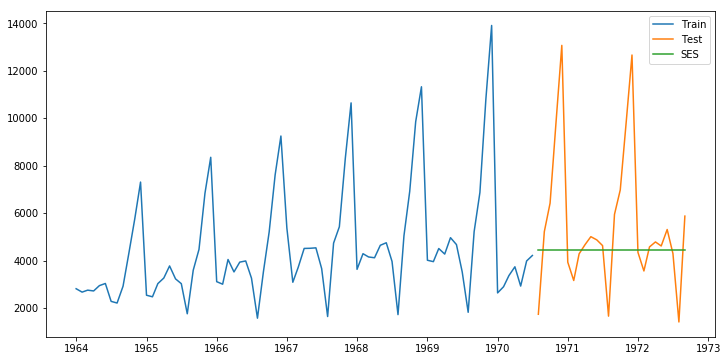

In [30]:
plt.figure(figsize=(12,6))
plt.plot(train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')

In [31]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales, y_hat_avg.SES))
rmse = round(rmse, 3)

In [32]:
# Mean Absolute Percentage Error
abs_error = np.abs(y_test['Sales']-y_hat_avg.SES)
actual = y_test['Sales']
mape = np.round(np.mean(abs_error/actual),4)

In [33]:
# Storing results in a dataframe
tempResultsDf = pd.DataFrame({'Method':['SES forecast'], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,Simple average forecast,3040.268,0.4084
0,Moving average forecast,1619.835,0.2830
0,SES forecast,3064.145,0.4068


# Model 4 :Holts Method

In [34]:
fit1 = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='None').fit()
fit1.params

{'smoothing_level': 0.868211893794132,
 'smoothing_slope': 0.0,
 'smoothing_seasonal': nan,
 'damping_slope': nan,
 'initial_level': 2814.879876149242,
 'initial_slope': 17.23765502204041,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [35]:
y_hat_avg['Holt'] = fit1.forecast(len(test))

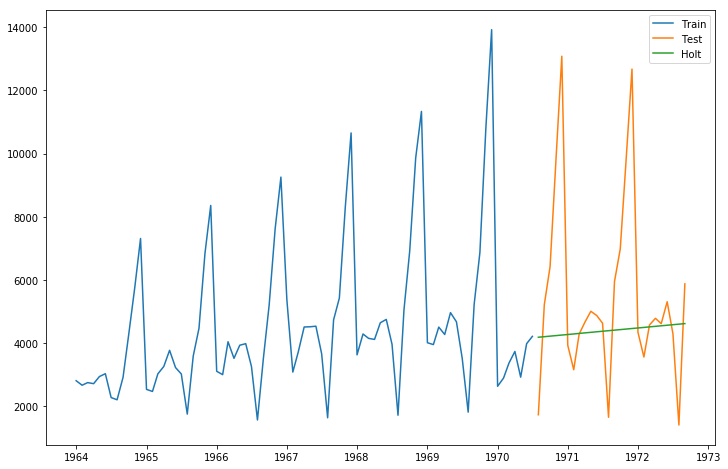

In [36]:
plt.figure(figsize=(12,8))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['Holt'], label='Holt')
plt.legend(loc='best')
plt.show()

In [37]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales, y_hat_avg.Holt))
rmse = round(rmse, 3)

In [38]:
# Mean Absolute Percentage Error
abs_error = np.abs(y_test['Sales']-y_hat_avg.Holt)
actual = y_test['Sales']
mape = np.round(np.mean(abs_error/actual),4)

In [39]:
# Storing results in a dataframe
tempResultsDf = pd.DataFrame({'Method':['Holt'], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,Simple average forecast,3040.268,0.4084
0,Moving average forecast,1619.835,0.2830
0,SES forecast,3064.145,0.4068
0,Holt,3097.743,0.4050


# Model 5 : Holt-Winters Method - Additive

In [40]:
y_hat_avg = test.copy()

In [41]:
fit1 = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='add').fit()
fit1.params

{'smoothing_level': 0.05574986291458101,
 'smoothing_slope': 1.443911683751581e-12,
 'smoothing_seasonal': 0.9053845872345992,
 'damping_slope': nan,
 'initial_level': 3339.9105862162864,
 'initial_slope': 22.2445016461074,
 'initial_seasons': array([ -630.65411606,  -773.57658123,  -687.91626227,  -723.9294304 ,
         -501.55137492,  -421.01244496, -1174.51840923, -1257.20818584,
         -539.11320431,   832.32560022,  2298.17467999,  3838.99033183]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [42]:
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))

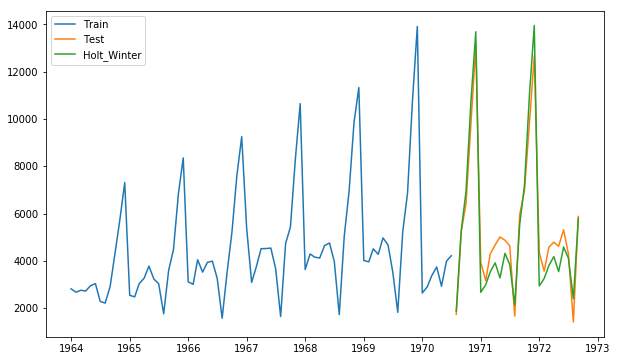

In [43]:
plt.figure(figsize=(10,6))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')

In [44]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales, y_hat_avg.Holt_Winter))
rmse = round(rmse, 3)

In [45]:
# Mean Absolute Percentage Error
abs_error = np.abs(y_test['Sales']-y_hat_avg.Holt_Winter)
actual = y_test['Sales']
mape = np.round(np.mean(abs_error/actual),4)

In [46]:
# Storing results in a dataframe
tempResultsDf = pd.DataFrame({'Method':['Holt Winter forecast - Additive'], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf

,Method,RMSE,MAPE
0,Simple average forecast,3040.268,0.4084
0,Moving average forecast,1619.835,0.2830
0,SES forecast,3064.145,0.4068
0,Holt,3097.743,0.4050
0,Holt Winter forecast - Additive,821.475,0.1574


# Model 6 : Holt-Winters Method - Multiplicative

In [47]:
y_hat_avg = test.copy()

In [48]:
fit1 = ExponentialSmoothing(np.asarray(train['Sales']) ,seasonal_periods=12 ,trend='add', seasonal='mul').fit()
fit1.params

{'smoothing_level': 0.1566896947485643,
 'smoothing_slope': 0.023488593329382416,
 'smoothing_seasonal': 0.0,
 'damping_slope': nan,
 'initial_level': 3447.727342405977,
 'initial_slope': 0.0,
 'initial_seasons': array([0.71143659, 0.66799192, 0.76000046, 0.77745663, 0.81963239,
        0.83515854, 0.70478854, 0.37374218, 0.87036828, 1.14636568,
        1.6990458 , 2.09435934]),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [49]:
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))

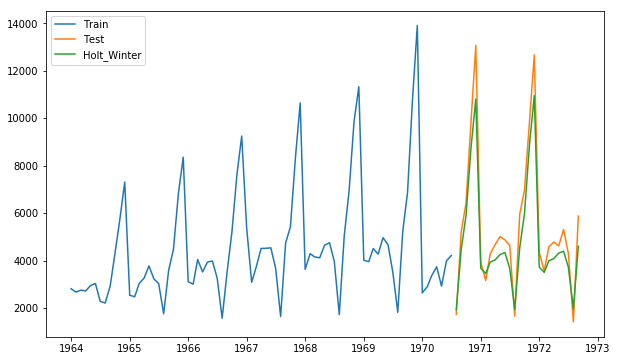

In [50]:
plt.figure(figsize=(10,6))
plt.plot( train['Sales'], label='Train')
plt.plot(test['Sales'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')

In [51]:
# Root Mean Square Error (RMSE)
rmse = np.sqrt(mean_squared_error(test.Sales, y_hat_avg.Holt_Winter))
rmse = round(rmse, 3)

In [52]:
# Mean Absolute Percentage Error
abs_error = np.abs(y_test['Sales']-y_hat_avg.Holt_Winter)
actual = y_test['Sales']
mape = np.round(np.mean(abs_error/actual),4)

In [54]:
# Storing results in a dataframe
tempResultsDf = pd.DataFrame({'Method':['Holt Winter forecast - Multiplicative'], 'RMSE': [rmse],'MAPE': [mape] })
resultsDf = pd.concat([resultsDf, tempResultsDf])
resultsDf = resultsDf[['Method', 'RMSE', 'MAPE']]
resultsDf.index = [i for i in range(len(resultsDf))]
resultsDf

,Method,RMSE,MAPE
0,Simple average forecast,3040.268,0.4084
1,Moving average forecast,1619.835,0.2830
2,SES forecast,3064.145,0.4068
3,Holt,3097.743,0.4050
4,Holt Winter forecast - Additive,821.475,0.1574
5,Holt Winter forecast - Multiplicative,899.251,0.1410


### Inference:
####      Simple Average Model -  It takes the overall average of the past data and applied it as prediction. Though it gives us the good mape score than linear regression it is Not applicable for all the cases.
####      Moving Average Model -  Since it captures the moving average in this case it is 2(Rolling Window). It captured the seasonality and gave better results.
####      Simple ES  Model     - It uses exponentially decreasing weight for past data . it is same like simple average except than smoothing(rate data at prior steps decay exponentially). But it works well with stationary data.
####      Holt   Model         - It captures the trend alone , as we can see the data has seasonality too. So it has performance is not up to the mark.
####      Holt Winter Model    - It captures both Trend and Seasonality hence it performed well among all the models.Both the Mape score and RMSE score are significantly less when compared with other models